# Deep4Chem_multi_task
- 3つの目的変数（Absorption max (nm), Emission max (nm), Lifetime (ns)）を同時に予測するGNNを構築する     
- 結果のまとめに関しては、`Deep4Chem_1task.ipynb`を参照。

## ライブラリ読み込み

In [ ]:
import sys
import copy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from rdkit import Chem
from rdkit import __version__ as rdkit_version
from rdkit.Chem import Draw

from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_add_pool
import torch_geometric

from tqdm import tqdm

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------------------------
# Device
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Environment info (for reproducibility)
# ------------------------------
print("===== Environment =====")
print(f"Python           : {sys.version.split()[0]}")
print(f"PyTorch          : {torch.__version__}")
print(f"PyTorch Geometric: {torch_geometric.__version__}")
print(f"RDKit            : {rdkit_version}")
if torch.cuda.is_available():
    print(f"CUDA version     : {torch.version.cuda}")
print("========================")
print("device:", device)

===== Environment =====
Python           : 3.9.23
PyTorch          : 2.2.1+cu121
PyTorch Geometric: 2.6.1
RDKit            : 2025.03.5
CUDA version     : 12.1
device: cuda


## データセット読み込み

In [2]:
# ダウンロードしたデータセットを読み込む
dataset = pd.read_csv("data/Deep4Chem/DB for chromophore_Sci_Data_rev02.csv", index_col=0)

dataset.head()

,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
Tag,,,,,,,,,,,,,
1,N#Cc1cc2ccc(O)cc2oc1=O,O,355.0,410.00,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.15370,DOI: 10.1021/acs.jpcb.5b09905
2,N#Cc1cc2ccc([O-])cc2oc1=O,O,408.0,450.00,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,DOI: 10.1021/acs.jpcb.5b09905
3,CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c...,ClC(Cl)Cl,526.0,535.00,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,https://doi.org/10.1002/smll.201901342
4,[O-]c1c(-c2nc3ccccc3s2)cc2ccc3cccc4ccc1c2c34,CC#N,514.0,553.72,3.810000,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,https://doi.org/10.1016/j.snb.2018.10.043
5,[O-]c1c(-c2nc3ccccc3s2)cc2ccc3cccc4ccc1c2c34,CS(C)=O,524.0,555.00,4.700000,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,https://doi.org/10.1016/j.snb.2018.10.043


In [3]:
# 目的変数列
target_cols = ["Absorption max (nm)", "Emission max (nm)", "Lifetime (ns)"]
required_cols = ["Chromophore", "Solvent"] + target_cols

# 必須列の存在チェック
missing_cols = [c for c in required_cols if c not in dataset.columns]
if missing_cols:
    raise ValueError(f"dataset に必要列がありません: {missing_cols}. columns={list(dataset.columns)}")

# 必要列だけ取り出し
df = dataset[required_cols].copy()

# SMILESは文字列化（NaN混入もあるので先に処理）
df["Chromophore"] = df["Chromophore"].astype(str)
df["Solvent"]     = df["Solvent"].astype(str)

# 目的変数は数値化（変換不能はNaNへ）
for col in target_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ターゲット欠損行を除外
df = df.dropna(subset=target_cols).reset_index(drop=True)
df = df[(df["Chromophore"] != "nan") & (df["Solvent"] != "nan")].reset_index(drop=True)

# 確認
print("Usable rows:", len(df))
display(df.head(3))

Usable rows: 5841


,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns)
0,N#Cc1cc2ccc(O)cc2oc1=O,O,355.0,410.0,2.804262
1,N#Cc1cc2ccc([O-])cc2oc1=O,O,408.0,450.0,3.961965
2,CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c...,ClC(Cl)Cl,526.0,535.0,3.602954


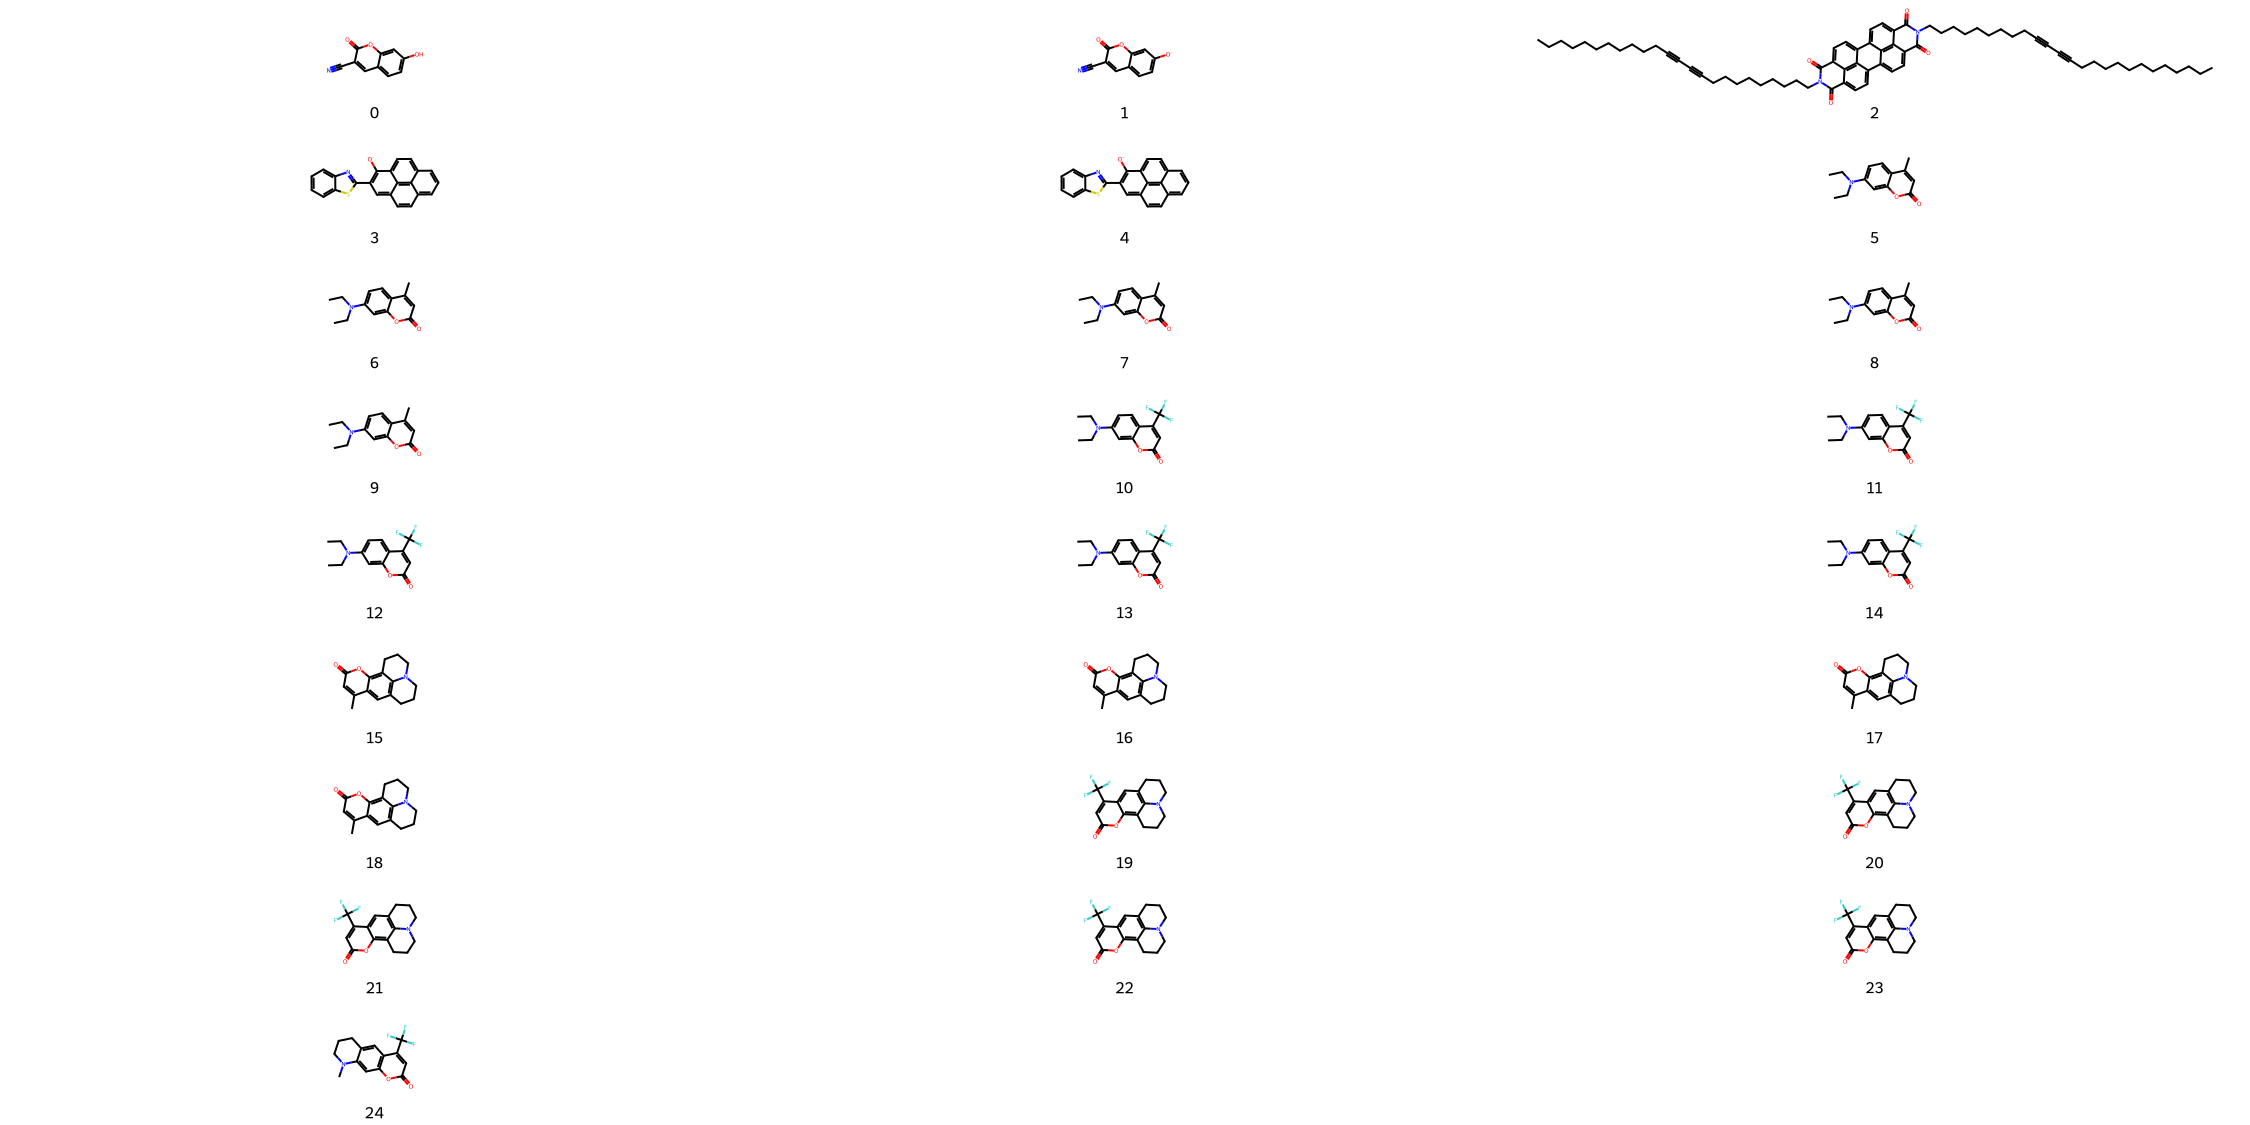

In [4]:
# 25分子を grid 形式で可視化（RDKit）
smiles_col = 'Chromophore'

# Mol生成（失敗したSMILESはNoneになる）
mols = []
legends = []
for i, smi in enumerate(df[smiles_col].astype(str).head(25)):
    m = Chem.MolFromSmiles(smi)
    mols.append(m)
    legends.append(f"{i}")

# 表示
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(750, 125),
    legends=legends
)
display(img)

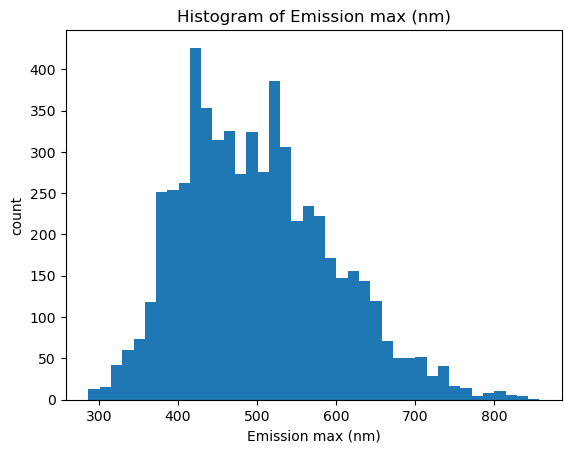

count: 5841
min / max: 286.615076 857.0
mean / std: 501.2407570637562 95.20425874155804
quantiles: {0.01: 328.0, 0.05: 369.0, 0.5: 492.0, 0.95: 670.0, 0.99: 746.0}


In [5]:
# 目的変数の可視化

# 目的変数のselect
target_col = "Emission max (nm)"
if target_col not in df.columns:
    raise ValueError(f"'{target_col}' 列がありません。利用可能列: {list(df.columns)}")

X = df[target_col].dropna()

plt.figure()
plt.hist(X, bins=40)
plt.title(f"Histogram of {target_col}")
plt.xlabel(f"{target_col}")
plt.ylabel("count")
plt.show()

print("count:", len(X))
print("min / max:", float(X.min()), float(X.max()))
print("mean / std:", float(X.mean()), float(X.std()))
print("quantiles:", X.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).to_dict())

In [ ]:
# ============================================================
# Hold-out split: train / val / test（ランダム分割）
# ============================================================

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    shuffle=True,
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(
    "Hold-out split sizes ->",
    "train:", len(train_df),
    "val:", len(val_df),
    "test:", len(test_df),
)

# ============================================================
# Robust scaling（train のみで fit）
# ============================================================

def fit_robust_scaler(y: pd.Series):
    y = y.astype(float)
    med = float(y.median())
    q1 = float(y.quantile(0.25))
    q3 = float(y.quantile(0.75))
    iqr = q3 - q1
    if iqr == 0:
        iqr = 1.0
    return med, iqr

def transform_robust(y, med, iqr):
    return (y.astype(float) - med) / iqr

def inverse_robust(y_scaled, med, iqr):
    return y_scaled * iqr + med

# ---- train データのみで scaler を fit ----
scalers = {col: fit_robust_scaler(train_df[col]) for col in target_cols}

# ---- train / val / test に同じ scaler を適用 ----
for split_df in (train_df, val_df, test_df):
    for col in target_cols:
        med, iqr = scalers[col]
        split_df[f"{col}_scaled"] = transform_robust(split_df[col], med, iqr)

# ============================================================
# 確認ログ（Emission max (nm) を代表として表示）
# ============================================================

rep_col = "Emission max (nm)"

print(
    f"[fit on train] {rep_col} median (raw):",
    scalers[rep_col][0],
    "IQR (raw):",
    scalers[rep_col][1],
)

print(
    f"[after scaling] {rep_col}_scaled median:",
    float(train_df[f"{rep_col}_scaled"].median()),
)

q1 = float(train_df[f"{rep_col}_scaled"].quantile(0.25))
q3 = float(train_df[f"{rep_col}_scaled"].quantile(0.75))
print(f"[after scaling] {rep_col}_scaled IQR:", q3 - q1)


Hold-out split sizes -> train: 4672 val: 584 test: 585
[fit on train] Emission max (nm) median (raw): 493.0 IQR (raw): 137.0
[after scaling] Emission max (nm)_scaled median: 0.0
[after scaling] Emission max (nm)_scaled IQR: 1.0


## SMILES→PyTorch Geometric Data変換（Dataset作成）

In [ ]:
# ============================================================
# Features + SMILES -> PyG Data 変換
# （論文準拠の離散特徴量）
# ============================================================

# ----------------------------
# 原子・結合の離散特徴量設定
# ----------------------------

# 原子番号・次数の上限（クリップ用）
MAX_ATOMIC_NUM = 100
MAX_DEGREE = 5

# 結合タイプ（論文中の B 行列選択に対応）
BOND_TYPES = {
    Chem.rdchem.BondType.SINGLE: 0,
    Chem.rdchem.BondType.DOUBLE: 1,
    Chem.rdchem.BondType.TRIPLE: 2,
    Chem.rdchem.BondType.AROMATIC: 3,
}
NUM_BOND_TYPES = 4

# ----------------------------
# 追加の原子特徴量
#  - 形式電荷
#  - 混成軌道
# ----------------------------

# 形式電荷（クリップして離散化）
MIN_FC, MAX_FC = -2, 2
FC_OFFSET = -MIN_FC               # -2..2 → 0..4
NUM_FC = (MAX_FC - MIN_FC + 1)

# 混成軌道タイプ
HYB_MAP = {
    Chem.rdchem.HybridizationType.SP: 0,
    Chem.rdchem.HybridizationType.SP2: 1,
    Chem.rdchem.HybridizationType.SP3: 2,
    Chem.rdchem.HybridizationType.SP3D: 3,
    Chem.rdchem.HybridizationType.SP3D2: 4,
}
HYB_UNKNOWN = 5
NUM_HYB = 6

def atom_features(atom: Chem.rdchem.Atom) -> torch.Tensor:
    """
    原子特徴量（すべて離散値）
    x[:, :] の各列の意味：
      x[:,0]: 原子番号（クリップあり）
      x[:,1]: 原子次数（クリップあり）
      x[:,2]: 芳香族フラグ（0/1）
      x[:,3]: 形式電荷（-2..2 を 0..4 に変換）
      x[:,4]: 混成軌道タイプ
    """
    atomic_num = min(atom.GetAtomicNum(), MAX_ATOMIC_NUM)
    degree = min(atom.GetDegree(), MAX_DEGREE)
    aromatic = int(atom.GetIsAromatic())

    # 形式電荷をクリップしてオフセット
    formal_charge = atom.GetFormalCharge()
    formal_charge = max(MIN_FC, min(formal_charge, MAX_FC)) + FC_OFFSET  # 0..NUM_FC-1

    # 混成軌道（未知は HYB_UNKNOWN）
    hyb_idx = HYB_MAP.get(atom.GetHybridization(), HYB_UNKNOWN)

    return torch.tensor([atomic_num, degree, aromatic, formal_charge, hyb_idx], dtype=torch.long)

def bond_features(bond: Chem.rdchem.Bond) -> torch.Tensor:
    """
    結合特徴量（離散）
    edge_attr[:, :] の各列の意味：
      edge_attr[:,0]: 結合タイプ（SINGLE/DOUBLE/TRIPLE/AROMATIC）
      edge_attr[:,1]: 共役フラグ（0/1）
      edge_attr[:,2]: 環内結合フラグ（0/1）
    """
    bond_type = BOND_TYPES.get(bond.GetBondType(), 0)
    conjugated = int(bond.GetIsConjugated())
    in_ring = int(bond.IsInRing())
    return torch.tensor([bond_type, conjugated, in_ring], dtype=torch.long)

def smiles_to_pyg(smiles: str):
    """
    SMILES 文字列を PyG の Data に変換（yは付けない）。
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.stack([atom_features(a) for a in mol.GetAtoms()], dim=0)  # [num_nodes, 5]

    edge_index_list = []
    edge_attr_list = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bf = bond_features(bond)
        edge_index_list.append([i, j]); edge_attr_list.append(bf)
        edge_index_list.append([j, i]); edge_attr_list.append(bf)

    if len(edge_index_list) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr  = torch.empty((0, 3), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr  = torch.stack(edge_attr_list, dim=0)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.smiles = smiles
    return data

class DyeSolventPairDataset(Dataset):
    """
    DataFrame（Chromophore, Solvent, target_cols_scaled）から
    (dye_data, sol_data, y) を返す Dataset
    """
    def __init__(self, df: pd.DataFrame, target_cols: list):
        self.samples = []
        bad = 0

        scaled_cols = [f"{col}_scaled" for col in target_cols]

        for _, row in df.iterrows():
            dye_smi = str(row["Chromophore"])
            sol_smi = str(row["Solvent"])

            dye_data = smiles_to_pyg(dye_smi)
            sol_data = smiles_to_pyg(sol_smi)

            if (dye_data is None) or (sol_data is None):
                bad += 1
                continue

            # y: shape [num_tasks]（後段で batch 化するなら [num_tasks] が扱いやすい）
            y_vals = [row[c] for c in scaled_cols]
            y = torch.tensor(y_vals, dtype=torch.float)  # [T]

            self.samples.append((dye_data, sol_data, y))

        print(f"Converted pairs: {len(self.samples)} / {len(df)} (invalid removed: {bad})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def collate_dye_solvent(batch):
    """
    1サンプルを(dye_i, sol_i, y_i)としてまとめる
    色素と溶媒は、同じ「分子グラフ」形式だが、入力としては2つの別オブジェクト
    """
    dye_list, sol_list, y_list = zip(*batch)
    dye_batch = Batch.from_data_list(list(dye_list))
    sol_batch = Batch.from_data_list(list(sol_list))
    y = torch.stack(list(y_list), dim=0)  # [B, T]
    return dye_batch, sol_batch, y

train_dataset = DyeSolventPairDataset(train_df, target_cols)
val_dataset   = DyeSolventPairDataset(val_df,   target_cols)
test_dataset  = DyeSolventPairDataset(test_df,  target_cols)

# quick check
dye0, sol0, y0 = train_dataset[0]
print(dye0)
print(sol0)
print("y:", y0, "shape:", y0.shape)

Converted pairs: 4672 / 4672 (invalid removed: 0)
Converted pairs: 584 / 584 (invalid removed: 0)
Converted pairs: 585 / 585 (invalid removed: 0)
Data(x=[82, 5], edge_index=[2, 176], edge_attr=[176, 3], smiles='CCCCCCCCCCOc1ccc(C#Cc2ccc(C#Cc3ccc(OCCCCCCCCCC)c(OCCCCCCCCCC)c3)c3nc4c5ccccc5c5ccccc5c4nc23)cc1OCCCCCCCCCC')
Data(x=[3, 5], edge_index=[2, 4], edge_attr=[4, 3], smiles='ClCCl')
y: tensor([0.5042, 0.5328, 1.2883]) shape: torch.Size([3])


In [ ]:
i = 0  # 確認したいサンプル番号
row = train_df.loc[i]

print("Chromophore:", row["Chromophore"])
print("Solvent    :", row["Solvent"])
print()

for col in target_cols:
    print(
        f"{col:>18s} raw={row[col]:10.4f}  scaled={row[f'{col}_scaled']:10.4f}"
    )

Chromophore: CCCCCCCCCCOc1ccc(C#Cc2ccc(C#Cc3ccc(OCCCCCCCCCC)c(OCCCCCCCCCC)c3)c3nc4c5ccccc5c5ccccc5c4nc23)cc1OCCCCCCCCCC
Solvent    : ClCCl

Absorption max (nm) raw=  461.0000  scaled=    0.5042
 Emission max (nm) raw=  566.0000  scaled=    0.5328
     Lifetime (ns) raw=    8.6560  scaled=    1.2883


### なぜコレート関数を使うのか

指定しなかった場合、PyTorch の DataLoader は、何も指定しないと default_collate を使う。     

---
もし、指定しないと、Datasetは     
```python
__getitem__ -> (dye_data, sol_data, y)
```
を返すので、default_collateは
```text
(
  [dye_data_1, dye_data_2, ..., dye_data_32],
  [sol_data_1, sol_data_2, ..., sol_data_32],
  [y_1, y_2, ..., y_32]
)
```
---
を作る、しかし、
- `dye_data_i`や`sol_data_i`は**PyG Data**(Tensorではない)
- default_collateは**PyG DataをBatchに変換できない**     
⇒結果として、GNNにそのままでは入力できなくなる

---
PyGの`Batch.from_data_list`は複数のグラフを**disjoint union**して`x`, `edge_index`, `edge_attr`, `batch`を正しく再構築する**グラフ専用collate**     
よって、`collate_dye_solvent`関数は、実質、
```python
dye_batch = Batch.from_data_list(dye_list)
sol_batch = Batch.from_data_list(sol_list)
y = torch.stack(y_list)
```
を明示的にやっているだけ

## PyG DataLoader（ミニバッチ化）＋ バッチの形確認

In [9]:
# DataLoader + sanity check
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_dye_solvent,
    drop_last=True,  # バッチサイズ1が混ざると学習が不安定になるため
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_dye_solvent,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_dye_solvent,
)

# 1バッチ取り出して形確認
dye_batch, sol_batch, y = next(iter(train_loader))

print("=== Dye batch ===")
print("x:", dye_batch.x.shape)
print("edge_index:", dye_batch.edge_index.shape)
print("edge_attr:", dye_batch.edge_attr.shape)
print("batch:", dye_batch.batch.shape)
print("num_graphs:", dye_batch.num_graphs)

print("\n=== Solvent batch ===")
print("x:", sol_batch.x.shape)
print("edge_index:", sol_batch.edge_index.shape)
print("edge_attr:", sol_batch.edge_attr.shape)
print("batch:", sol_batch.batch.shape)
print("num_graphs:", sol_batch.num_graphs)

print("\n=== Target ===")
print("y:", y.shape)   # [B, T]

# GPU に乗せる
dye_batch = dye_batch.to(device)
sol_batch = sol_batch.to(device)
y = y.to(device)
print("Moved to device OK")

=== Dye batch ===
x: torch.Size([998, 5])
edge_index: torch.Size([2, 2214])
edge_attr: torch.Size([2214, 3])
batch: torch.Size([998])
num_graphs: 32

=== Solvent batch ===
x: torch.Size([197, 5])
edge_index: torch.Size([2, 364])
edge_attr: torch.Size([364, 3])
batch: torch.Size([197])
num_graphs: 32

=== Target ===
y: torch.Size([32, 3])
Moved to device OK


## 2D-only MPNN（PyG）モデル定義（Embedding → MessagePassing → Pooling → 回帰）

In [10]:
class EdgeCondLinearLayer(MessagePassing):
    """
    m_{ij} = W_{bond_type} h_j
    を作ってから、GRUでノード状態を更新する層。
    """
    def __init__(self, hidden_dim: int, num_bond_types: int):
        super().__init__(aggr="add")  # 近傍メッセージを加算で集約
        self.hidden_dim = hidden_dim
        self.num_bond_types = num_bond_types

        # 結合タイプごとの重み行列 W_e: [T, H, H]
        self.W = nn.Parameter(torch.empty(num_bond_types, hidden_dim, hidden_dim))
        nn.init.xavier_uniform_(self.W)

        # GRU: input=message, hidden=old_state
        self.gru = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(self, x, edge_index, bond_type):
        """
        x        : [N, H]  ノード表現
        edge_index: [2, E] 有向エッジ
        bond_type : [E]    エッジごとの結合タイプ（0..T-1）
        """
        # propagate() は message() を呼び、aggr="add" でノードごとに集約する
        m = self.propagate(edge_index, x=x, bond_type=bond_type)  # [N, H]

        # GRUで更新（input=m, hx=x）
        x_out = self.gru(m, x)  # [N, H]
        return x_out

    def message(self, x_j, bond_type):
        """
        x_j      : [E, H]  エッジの送信元ノード表現（j側）
        bond_type: [E]     結合タイプ
        """
        bt = bond_type.to(torch.long).clamp(0, self.num_bond_types - 1)  # 安全のため範囲に収める

        # エッジごとに W_{bt} を選ぶ → [E, H, H]
        W_bt = self.W[bt]

        # m_ij = W_{bt} @ h_j
        m = torch.bmm(W_bt, x_j.unsqueeze(-1)).squeeze(-1)  # [E, H]
        return m

class MPNNEncoder(nn.Module):
    """
    分子グラフ -> 1024-d fingerprint を出すエンコーダ
    """
    def __init__(
        self,
        hidden_dim: int = 128,
        num_layers: int = 3,
        dropout: float = 0.0,
        fp_dim: int = 1024,
    ):
        super().__init__()

        # ノード特徴の埋め込み
        self.emb_atomic = nn.Embedding(MAX_ATOMIC_NUM + 1, 64)
        self.emb_degree = nn.Embedding(MAX_DEGREE + 1, 16)
        self.emb_aroma  = nn.Embedding(2, 8)
        self.emb_fc     = nn.Embedding(NUM_FC, 8)
        self.emb_hyb    = nn.Embedding(NUM_HYB, 8)

        node_in_dim = 64 + 16 + 8 + 8 + 8  # 104
        self.node_proj = nn.Linear(node_in_dim, hidden_dim)

        self.layers = nn.ModuleList([
            EdgeCondLinearLayer(hidden_dim=hidden_dim, num_bond_types=NUM_BOND_TYPES)
            for _ in range(num_layers)
        ])

        self.fp_dim = fp_dim
        self.node_to_fp = nn.Linear(hidden_dim, self.fp_dim)
        self.dropout = dropout

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_attr  = data.edge_attr
        batch      = data.batch

        atomic_num    = x[:, 0].clamp(0, MAX_ATOMIC_NUM)
        degree        = x[:, 1].clamp(0, MAX_DEGREE)
        aromatic      = x[:, 2].clamp(0, 1)
        formal_charge = x[:, 3].clamp(0, NUM_FC - 1)
        hybridization = x[:, 4].clamp(0, NUM_HYB - 1)

        h = torch.cat([
            self.emb_atomic(atomic_num),
            self.emb_degree(degree),
            self.emb_aroma(aromatic),
            self.emb_fc(formal_charge),
            self.emb_hyb(hybridization),
        ], dim=-1)  # [N, 104]

        h = self.node_proj(h)  # [N, hidden_dim]

        bond_type = edge_attr[:, 0].clamp(0, NUM_BOND_TYPES - 1)  # [E]

        for layer in self.layers:
            h = layer(h, edge_index, bond_type)

        h_fp = self.node_to_fp(h)              # [N, fp_dim]
        g    = global_add_pool(h_fp, batch)    # [B, fp_dim], Lossが暴れるなら、global_mean_pool に変更

        if self.dropout > 0:
            g = F.dropout(g, p=self.dropout, training=self.training)

        return g  # [B, fp_dim]

class DyeSolventMPNNRegressor(nn.Module):
    def __init__(
        self,
        hidden_dim: int = 128,
        num_layers: int = 3,
        fp_dim: int = 1024,
        num_targets: int = 3,
        dropout: float = 0.0,
        share_encoder: bool = False,  # Trueなら色素と溶媒で重み共有
    ):
        super().__init__()

        enc = MPNNEncoder(hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, fp_dim=fp_dim)
        if share_encoder:
            self.dye_encoder = enc
            self.sol_encoder = enc
        else:
            self.dye_encoder = enc
            self.sol_encoder = MPNNEncoder(hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, fp_dim=fp_dim)

        in_dim = fp_dim * 2
        self.fc1 = nn.Linear(in_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.out = nn.Linear(256, num_targets)
        self.dropout = dropout

    def forward(self, dye_batch, sol_batch):
        h_dye = self.dye_encoder(dye_batch)  # [B, fp_dim]
        h_sol = self.sol_encoder(sol_batch)  # [B, fp_dim]

        h = torch.cat([h_dye, h_sol], dim=1)  # [B, 2*fp_dim]

        z = F.relu(self.bn1(self.fc1(h)))
        if self.dropout > 0:
            z = F.dropout(z, p=self.dropout, training=self.training)

        z = F.relu(self.bn2(self.fc2(z)))
        if self.dropout > 0:
            z = F.dropout(z, p=self.dropout, training=self.training)

        return self.out(z)  # [B, num_targets]

In [11]:
# sanity check
model = DyeSolventMPNNRegressor(num_targets=len(target_cols)).to(device)

dye_batch, sol_batch, y = next(iter(train_loader))
dye_batch = dye_batch.to(device)
sol_batch = sol_batch.to(device)

pred = model(dye_batch, sol_batch)
print("pred.shape:", pred.shape)  # [B, 3]
print('pred', pred)

pred.shape: torch.Size([32, 3])
pred tensor([[ 0.3348,  0.4117, -0.3283],
        [ 0.0628,  0.0677, -0.3216],
        [-0.0182,  0.6137, -0.5304],
        [ 0.1335,  0.1147, -0.2921],
        [ 0.3577,  0.7673, -0.8072],
        [-0.0503,  0.1964, -0.2906],
        [-0.1121,  0.3808, -0.6087],
        [-0.2041,  0.3604, -0.6061],
        [ 0.3358,  0.7693, -0.3601],
        [ 0.0416,  0.4283, -0.2374],
        [-0.1456,  0.3203, -0.5263],
        [ 0.1266,  0.3987, -0.2546],
        [ 0.0016,  0.1034, -0.5085],
        [-0.3657,  0.2810,  0.1543],
        [ 0.3988,  0.7422, -0.1265],
        [-0.2238, -0.0059, -0.0014],
        [ 0.3332,  0.9952, -0.0879],
        [ 0.1513,  0.3409, -0.6313],
        [ 0.0099,  0.5738, -0.6933],
        [ 0.1819,  0.0469, -0.1514],
        [-0.0791,  0.7597, -0.2500],
        [ 0.3472,  0.4088, -0.5873],
        [-0.2866,  0.6406, -0.6319],
        [ 0.0150,  0.3458, -0.5682],
        [-0.0699,  0.2860, -0.4763],
        [ 0.3740,  0.6753, -0.4348],
 

## 学習・評価

In [12]:
# --- 損失関数 ---
# マルチタスク回帰（8物性）なので、各要素の MSE の平均をとる
criterion = nn.MSELoss()

# --- 最適化手法 ---
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# --- 学習率スケジューラ ---
# 論文の「エポックごとに 2×10^-6 の減衰」を
# 指数減衰として解釈し、epoch ごとに lr を少しずつ下げる
#   lr_{t+1} = lr_t * (1 - 2e-6)
decay = 2e-6
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: (1.0 - decay) ** epoch
)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_mae = 0.0
    n = 0

    for dye_batch, sol_batch, y in tqdm(loader, desc="train", leave=False):
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)
        y = y.to(device).float()  # [B, T]

        optimizer.zero_grad()

        pred = model(dye_batch, sol_batch)  # [B, T]
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            mae = torch.mean(torch.abs(pred - y))

        bsz = y.size(0)
        total_loss += loss.item() * bsz
        total_mae  += mae.item()  * bsz
        n += bsz

    return total_loss / n, total_mae / n

@torch.no_grad()
def evaluate_scaled(model, loader, device, target_cols):
    model.eval()
    preds, ys = [], []

    for dye_batch, sol_batch, y in tqdm(loader, desc="eval_scaled", leave=False):
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)

        pred = model(dye_batch, sol_batch).cpu()  # [B, T]
        y = y.cpu()                                # [B, T]
        preds.append(pred)
        ys.append(y)

    preds = torch.cat(preds, dim=0)  # [N, T]
    ys    = torch.cat(ys, dim=0)     # [N, T]

    results = {}
    for i, col in enumerate(target_cols):
        resid = preds[:, i] - ys[:, i]
        mae = resid.abs().mean().item()
        rmse = torch.sqrt((resid ** 2).mean()).item()

        y_mean = ys[:, i].mean()
        ss_tot = torch.sum((ys[:, i] - y_mean) ** 2)
        ss_res = torch.sum(resid ** 2)
        r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

        results[col] = {"mae": mae, "rmse": rmse, "r2": r2}

    return results

@torch.no_grad()
def evaluate_raw(model, loader, device, target_cols, scalers):
    model.eval()
    preds, ys = [], []

    for dye_batch, sol_batch, y in tqdm(loader, desc="eval_raw", leave=False):
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)

        pred = model(dye_batch, sol_batch).cpu()  # scaled
        y = y.cpu()                                # scaled
        preds.append(pred)
        ys.append(y)

    preds = torch.cat(preds, dim=0)
    ys    = torch.cat(ys, dim=0)

    results = {}
    for i, col in enumerate(target_cols):
        med, iqr = scalers[col]

        pred_raw = preds[:, i] * iqr + med
        y_raw    = ys[:, i] * iqr + med

        resid = pred_raw - y_raw
        mae = resid.abs().mean().item()
        rmse = torch.sqrt((resid ** 2).mean()).item()

        y_mean = y_raw.mean()
        ss_tot = torch.sum((y_raw - y_mean) ** 2)
        ss_res = torch.sum(resid ** 2)
        r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

        results[col] = {"mae": mae, "rmse": rmse, "r2": r2}

    return results

def results_to_df(results: dict, title: str):
    """
    評価結果を DataFrame にまとめて表示
    """
    dfm = pd.DataFrame(results).T
    dfm.index.name = "target"
    dfm = dfm[["mae", "rmse", "r2"]]
    print(f"\n[{title}]")
    print(dfm)
    return dfm

In [13]:
# 学習条件
max_epochs = 500
patience = 20

# 監視対象（target_cols から選ぶ）
monitor_col = "Emission max (nm)"
monitor_key = "rmse"  # "rmse" or "mae"

best_metric = float("inf")
best_state = None
bad_epochs = 0
history = []

for epoch in range(1, max_epochs + 1):

    # 1) Train
    train_mse, train_mae = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # 2) Validation (scaled)
    val_scaled = evaluate_scaled(
        model, val_loader, device, target_cols
    )

    # early stopping 用の現在値
    if monitor_col not in val_scaled:
        raise KeyError(f"monitor_col='{monitor_col}' が val_scaled にありません。target_cols={target_cols}")
    current = val_scaled[monitor_col][monitor_key]

    # 3) LR scheduler
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]

    # 4) ログ（全ターゲットを簡潔に表示）
    msg_targets = " | ".join(
        [f"{col}: RMSE={val_scaled[col]['rmse']:.4f} MAE={val_scaled[col]['mae']:.4f} R2={val_scaled[col]['r2']:.4f}"
         for col in target_cols]
    )
    print(
        f"[Epoch {epoch:03d}] lr={lr:.2e} "
        f"train_MSE={train_mse:.4f} train_MAE={train_mae:.4f} | "
        f"VAL {msg_targets}"
    )

    # ログ保存（targetごとに rmse を入れる）
    rec = {
        "epoch": epoch,
        "lr": lr,
        "train_mse": train_mse,
        "train_mae": train_mae,
    }
    for col in target_cols:
        rec[f"val_{col}_rmse"] = val_scaled[col]["rmse"]
        rec[f"val_{col}_mae"]  = val_scaled[col]["mae"]
        rec[f"val_{col}_r2"]   = val_scaled[col]["r2"]
    history.append(rec)

    # 5) Early stopping
    if current < best_metric - 1e-6:
        best_metric = current
        best_state = copy.deepcopy(model.state_dict())
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(
                f"Early stopping triggered (patience={patience}). "
                f"Best VAL {monitor_col}_{monitor_key}={best_metric:.4f}"
            )
            break

# 最良モデルを復元、最終評価

if best_state is not None:
    model.load_state_dict(best_state)

model.to(device).eval()

val_scaled_best = evaluate_scaled(model, val_loader, device, target_cols)
print("\n===== BEST MODEL: VAL (scaled) =====")
print(f"monitor: {monitor_col}_{monitor_key} = {val_scaled_best[monitor_col][monitor_key]:.4f}")

# --- Test (scaled) ---
test_scaled = evaluate_scaled(model, test_loader, device, target_cols)
# --- Test (raw) ---
test_raw = evaluate_raw(model, test_loader, device, target_cols, scalers)

print("\n===== FINAL TEST (scaled space) =====")
for col in target_cols:
    print(col, test_scaled[col])

print("\n===== FINAL TEST (raw space) =====")
for col in target_cols:
    print(col, test_raw[col])

test_scaled_df = results_to_df(test_scaled, "TEST scaled metrics")
test_raw_df    = results_to_df(test_raw,    "TEST raw metrics")

[Epoch 001] lr=1.00e-03 train_MSE=4.8929 train_MAE=0.7183 | VAL Absorption max (nm): RMSE=0.8854 MAE=0.7651 R2=-0.4621 | Emission max (nm): RMSE=0.8583 MAE=0.7393 R2=-0.6687 | Lifetime (ns): RMSE=2.7806 MAE=1.0320 R2=0.0823


[Epoch 002] lr=1.00e-03 train_MSE=4.6427 train_MAE=0.6900 | VAL Absorption max (nm): RMSE=0.8413 MAE=0.6978 R2=-0.3199 | Emission max (nm): RMSE=0.6363 MAE=0.5373 R2=0.0827 | Lifetime (ns): RMSE=3.2815 MAE=2.2421 R2=-0.2782


[Epoch 003] lr=1.00e-03 train_MSE=4.4701 train_MAE=0.6757 | VAL Absorption max (nm): RMSE=0.6233 MAE=0.4676 R2=0.2755 | Emission max (nm): RMSE=0.5360 MAE=0.4203 R2=0.3491 | Lifetime (ns): RMSE=2.6815 MAE=1.0237 R2=0.1465


[Epoch 004] lr=1.00e-03 train_MSE=4.3607 train_MAE=0.6744 | VAL Absorption max (nm): RMSE=0.4417 MAE=0.3417 R2=0.6361 | Emission max (nm): RMSE=0.4716 MAE=0.3732 R2=0.4962 | Lifetime (ns): RMSE=2.4732 MAE=1.0453 R2=0.2739


[Epoch 005] lr=1.00e-03 train_MSE=4.3219 train_MAE=0.6610 | VAL Absorption max (nm): RMSE=0.4450 MAE=0.3370 R2=0.6306 | Emission max (nm): RMSE=0.4542 MAE=0.3615 R2=0.5327 | Lifetime (ns): RMSE=2.6503 MAE=0.9827 R2=0.1663


[Epoch 006] lr=1.00e-03 train_MSE=4.2884 train_MAE=0.6474 | VAL Absorption max (nm): RMSE=0.4509 MAE=0.3399 R2=0.6207 | Emission max (nm): RMSE=0.5067 MAE=0.4080 R2=0.4183 | Lifetime (ns): RMSE=2.5535 MAE=0.9557 R2=0.2260


[Epoch 007] lr=1.00e-03 train_MSE=4.0891 train_MAE=0.6354 | VAL Absorption max (nm): RMSE=0.4801 MAE=0.3770 R2=0.5701 | Emission max (nm): RMSE=0.4850 MAE=0.3821 R2=0.4670 | Lifetime (ns): RMSE=2.4178 MAE=1.1353 R2=0.3061


[Epoch 008] lr=1.00e-03 train_MSE=4.2006 train_MAE=0.6535 | VAL Absorption max (nm): RMSE=0.4394 MAE=0.3350 R2=0.6399 | Emission max (nm): RMSE=0.4290 MAE=0.3445 R2=0.5830 | Lifetime (ns): RMSE=2.4794 MAE=1.0873 R2=0.2703


[Epoch 009] lr=1.00e-03 train_MSE=4.0410 train_MAE=0.6084 | VAL Absorption max (nm): RMSE=0.4732 MAE=0.3684 R2=0.5823 | Emission max (nm): RMSE=0.4928 MAE=0.4014 R2=0.4499 | Lifetime (ns): RMSE=2.3257 MAE=1.0235 R2=0.3580


[Epoch 010] lr=1.00e-03 train_MSE=4.1965 train_MAE=0.6368 | VAL Absorption max (nm): RMSE=0.4996 MAE=0.3837 R2=0.5345 | Emission max (nm): RMSE=0.5377 MAE=0.4189 R2=0.3451 | Lifetime (ns): RMSE=2.2579 MAE=1.0990 R2=0.3949


[Epoch 011] lr=1.00e-03 train_MSE=3.7088 train_MAE=0.6082 | VAL Absorption max (nm): RMSE=0.9298 MAE=0.7166 R2=-0.6122 | Emission max (nm): RMSE=0.8258 MAE=0.6499 R2=-0.5448 | Lifetime (ns): RMSE=2.3489 MAE=1.1466 R2=0.3451


[Epoch 012] lr=1.00e-03 train_MSE=4.1677 train_MAE=0.6325 | VAL Absorption max (nm): RMSE=0.4495 MAE=0.3327 R2=0.6233 | Emission max (nm): RMSE=0.4347 MAE=0.3475 R2=0.5720 | Lifetime (ns): RMSE=2.2569 MAE=0.9706 R2=0.3954


[Epoch 013] lr=1.00e-03 train_MSE=3.9550 train_MAE=0.6131 | VAL Absorption max (nm): RMSE=0.4328 MAE=0.3286 R2=0.6507 | Emission max (nm): RMSE=0.4470 MAE=0.3570 R2=0.5473 | Lifetime (ns): RMSE=2.2856 MAE=0.9420 R2=0.3799


[Epoch 014] lr=1.00e-03 train_MSE=3.8794 train_MAE=0.6068 | VAL Absorption max (nm): RMSE=0.3894 MAE=0.2914 R2=0.7172 | Emission max (nm): RMSE=0.4203 MAE=0.3212 R2=0.5999 | Lifetime (ns): RMSE=2.1691 MAE=0.9684 R2=0.4415


[Epoch 015] lr=1.00e-03 train_MSE=3.7685 train_MAE=0.5953 | VAL Absorption max (nm): RMSE=0.5022 MAE=0.4132 R2=0.5296 | Emission max (nm): RMSE=0.5438 MAE=0.4500 R2=0.3300 | Lifetime (ns): RMSE=2.1402 MAE=0.9522 R2=0.4563


[Epoch 016] lr=1.00e-03 train_MSE=3.8442 train_MAE=0.6190 | VAL Absorption max (nm): RMSE=0.4257 MAE=0.3110 R2=0.6621 | Emission max (nm): RMSE=0.4539 MAE=0.3428 R2=0.5333 | Lifetime (ns): RMSE=2.3396 MAE=1.1503 R2=0.3502


[Epoch 017] lr=1.00e-03 train_MSE=3.8464 train_MAE=0.6051 | VAL Absorption max (nm): RMSE=0.5675 MAE=0.4324 R2=0.3995 | Emission max (nm): RMSE=0.5239 MAE=0.4211 R2=0.3782 | Lifetime (ns): RMSE=2.1661 MAE=1.2131 R2=0.4431


[Epoch 018] lr=1.00e-03 train_MSE=3.6872 train_MAE=0.6137 | VAL Absorption max (nm): RMSE=0.4123 MAE=0.3020 R2=0.6829 | Emission max (nm): RMSE=0.4459 MAE=0.3382 R2=0.5497 | Lifetime (ns): RMSE=2.1210 MAE=0.9408 R2=0.4660


[Epoch 019] lr=1.00e-03 train_MSE=3.7969 train_MAE=0.5957 | VAL Absorption max (nm): RMSE=0.3750 MAE=0.2921 R2=0.7377 | Emission max (nm): RMSE=0.4228 MAE=0.3321 R2=0.5950 | Lifetime (ns): RMSE=2.3078 MAE=1.2318 R2=0.3678


[Epoch 020] lr=1.00e-03 train_MSE=3.9767 train_MAE=0.6053 | VAL Absorption max (nm): RMSE=0.4817 MAE=0.3862 R2=0.5672 | Emission max (nm): RMSE=0.5729 MAE=0.4652 R2=0.2565 | Lifetime (ns): RMSE=2.7332 MAE=1.3054 R2=0.1132


[Epoch 021] lr=1.00e-03 train_MSE=3.7633 train_MAE=0.6061 | VAL Absorption max (nm): RMSE=0.4182 MAE=0.2999 R2=0.6738 | Emission max (nm): RMSE=0.4709 MAE=0.3587 R2=0.4976 | Lifetime (ns): RMSE=2.4344 MAE=1.3800 R2=0.2966


[Epoch 022] lr=1.00e-03 train_MSE=3.6758 train_MAE=0.5878 | VAL Absorption max (nm): RMSE=0.3985 MAE=0.2900 R2=0.7038 | Emission max (nm): RMSE=0.4168 MAE=0.3316 R2=0.6065 | Lifetime (ns): RMSE=2.1163 MAE=0.8731 R2=0.4684


[Epoch 023] lr=1.00e-03 train_MSE=3.4798 train_MAE=0.5778 | VAL Absorption max (nm): RMSE=0.3965 MAE=0.2891 R2=0.7067 | Emission max (nm): RMSE=0.4168 MAE=0.3242 R2=0.6065 | Lifetime (ns): RMSE=2.1158 MAE=0.8756 R2=0.4686


[Epoch 024] lr=1.00e-03 train_MSE=3.7008 train_MAE=0.6055 | VAL Absorption max (nm): RMSE=0.4298 MAE=0.3438 R2=0.6555 | Emission max (nm): RMSE=0.4257 MAE=0.3439 R2=0.5895 | Lifetime (ns): RMSE=2.2328 MAE=1.1879 R2=0.4082


[Epoch 025] lr=1.00e-03 train_MSE=3.7274 train_MAE=0.6059 | VAL Absorption max (nm): RMSE=0.4565 MAE=0.3674 R2=0.6113 | Emission max (nm): RMSE=0.4813 MAE=0.3983 R2=0.4752 | Lifetime (ns): RMSE=2.1089 MAE=0.9986 R2=0.4721


[Epoch 026] lr=1.00e-03 train_MSE=3.4462 train_MAE=0.5882 | VAL Absorption max (nm): RMSE=0.4179 MAE=0.3147 R2=0.6743 | Emission max (nm): RMSE=0.4142 MAE=0.3238 R2=0.6114 | Lifetime (ns): RMSE=2.2392 MAE=0.9260 R2=0.4048


[Epoch 027] lr=1.00e-03 train_MSE=3.7127 train_MAE=0.6067 | VAL Absorption max (nm): RMSE=0.4768 MAE=0.3513 R2=0.5759 | Emission max (nm): RMSE=0.4624 MAE=0.3565 R2=0.5156 | Lifetime (ns): RMSE=2.1248 MAE=0.8563 R2=0.4641


[Epoch 028] lr=1.00e-03 train_MSE=3.6382 train_MAE=0.6017 | VAL Absorption max (nm): RMSE=0.4430 MAE=0.3389 R2=0.6339 | Emission max (nm): RMSE=0.4556 MAE=0.3607 R2=0.5298 | Lifetime (ns): RMSE=2.0073 MAE=0.9302 R2=0.5217


[Epoch 029] lr=1.00e-03 train_MSE=3.8832 train_MAE=0.6177 | VAL Absorption max (nm): RMSE=0.4095 MAE=0.3195 R2=0.6873 | Emission max (nm): RMSE=0.4428 MAE=0.3531 R2=0.5558 | Lifetime (ns): RMSE=2.0712 MAE=1.0026 R2=0.4908


[Epoch 030] lr=1.00e-03 train_MSE=3.4985 train_MAE=0.5900 | VAL Absorption max (nm): RMSE=0.3886 MAE=0.2954 R2=0.7184 | Emission max (nm): RMSE=0.4264 MAE=0.3329 R2=0.5882 | Lifetime (ns): RMSE=1.9810 MAE=0.8783 R2=0.5342


[Epoch 031] lr=1.00e-03 train_MSE=3.3468 train_MAE=0.5772 | VAL Absorption max (nm): RMSE=0.4268 MAE=0.3269 R2=0.6603 | Emission max (nm): RMSE=0.4329 MAE=0.3473 R2=0.5755 | Lifetime (ns): RMSE=2.2476 MAE=1.0220 R2=0.4004


[Epoch 032] lr=1.00e-03 train_MSE=3.7052 train_MAE=0.5975 | VAL Absorption max (nm): RMSE=0.3911 MAE=0.2877 R2=0.7148 | Emission max (nm): RMSE=0.3985 MAE=0.3099 R2=0.6403 | Lifetime (ns): RMSE=2.0016 MAE=0.9542 R2=0.5244


[Epoch 033] lr=1.00e-03 train_MSE=3.4424 train_MAE=0.5897 | VAL Absorption max (nm): RMSE=0.5295 MAE=0.4055 R2=0.4770 | Emission max (nm): RMSE=0.5137 MAE=0.3932 R2=0.4021 | Lifetime (ns): RMSE=2.0627 MAE=1.0063 R2=0.4950


[Epoch 034] lr=1.00e-03 train_MSE=3.3823 train_MAE=0.5907 | VAL Absorption max (nm): RMSE=0.4189 MAE=0.3226 R2=0.6727 | Emission max (nm): RMSE=0.4248 MAE=0.3358 R2=0.5913 | Lifetime (ns): RMSE=2.0319 MAE=1.0974 R2=0.5099


[Epoch 035] lr=1.00e-03 train_MSE=3.8012 train_MAE=0.6158 | VAL Absorption max (nm): RMSE=0.5262 MAE=0.3884 R2=0.4836 | Emission max (nm): RMSE=0.5266 MAE=0.4153 R2=0.3718 | Lifetime (ns): RMSE=2.2637 MAE=0.9183 R2=0.3918


[Epoch 036] lr=1.00e-03 train_MSE=3.5312 train_MAE=0.6057 | VAL Absorption max (nm): RMSE=0.4191 MAE=0.3188 R2=0.6724 | Emission max (nm): RMSE=0.4453 MAE=0.3632 R2=0.5508 | Lifetime (ns): RMSE=2.2018 MAE=0.9057 R2=0.4246


[Epoch 037] lr=1.00e-03 train_MSE=3.4741 train_MAE=0.5943 | VAL Absorption max (nm): RMSE=0.6755 MAE=0.5249 R2=0.1491 | Emission max (nm): RMSE=0.6096 MAE=0.5052 R2=0.1583 | Lifetime (ns): RMSE=2.2363 MAE=0.9200 R2=0.4064


[Epoch 038] lr=1.00e-03 train_MSE=3.5678 train_MAE=0.6051 | VAL Absorption max (nm): RMSE=0.4163 MAE=0.3138 R2=0.6768 | Emission max (nm): RMSE=0.4352 MAE=0.3450 R2=0.5709 | Lifetime (ns): RMSE=2.0040 MAE=0.9571 R2=0.5233


[Epoch 039] lr=1.00e-03 train_MSE=3.5936 train_MAE=0.6058 | VAL Absorption max (nm): RMSE=0.4163 MAE=0.3283 R2=0.6768 | Emission max (nm): RMSE=0.4403 MAE=0.3550 R2=0.5608 | Lifetime (ns): RMSE=2.1525 MAE=0.9143 R2=0.4501


[Epoch 040] lr=1.00e-03 train_MSE=3.3173 train_MAE=0.5872 | VAL Absorption max (nm): RMSE=0.4505 MAE=0.3380 R2=0.6215 | Emission max (nm): RMSE=0.4705 MAE=0.3694 R2=0.4985 | Lifetime (ns): RMSE=2.0418 MAE=1.0030 R2=0.5051


[Epoch 041] lr=1.00e-03 train_MSE=3.4703 train_MAE=0.6100 | VAL Absorption max (nm): RMSE=0.4552 MAE=0.3388 R2=0.6136 | Emission max (nm): RMSE=0.4607 MAE=0.3620 R2=0.5192 | Lifetime (ns): RMSE=1.9567 MAE=0.9635 R2=0.5456


[Epoch 042] lr=1.00e-03 train_MSE=3.7109 train_MAE=0.6080 | VAL Absorption max (nm): RMSE=0.4156 MAE=0.3079 R2=0.6779 | Emission max (nm): RMSE=0.4285 MAE=0.3409 R2=0.5840 | Lifetime (ns): RMSE=1.8649 MAE=0.8417 R2=0.5872


[Epoch 043] lr=1.00e-03 train_MSE=3.3690 train_MAE=0.5837 | VAL Absorption max (nm): RMSE=0.4158 MAE=0.3138 R2=0.6776 | Emission max (nm): RMSE=0.4274 MAE=0.3375 R2=0.5861 | Lifetime (ns): RMSE=1.7651 MAE=0.8551 R2=0.6302


[Epoch 044] lr=1.00e-03 train_MSE=3.3440 train_MAE=0.5819 | VAL Absorption max (nm): RMSE=0.4086 MAE=0.3165 R2=0.6886 | Emission max (nm): RMSE=0.4224 MAE=0.3413 R2=0.5957 | Lifetime (ns): RMSE=1.7933 MAE=0.8717 R2=0.6183


[Epoch 045] lr=1.00e-03 train_MSE=3.2140 train_MAE=0.5784 | VAL Absorption max (nm): RMSE=0.4976 MAE=0.3652 R2=0.5382 | Emission max (nm): RMSE=0.4686 MAE=0.3675 R2=0.5027 | Lifetime (ns): RMSE=1.8517 MAE=0.9380 R2=0.5930


[Epoch 046] lr=1.00e-03 train_MSE=3.2701 train_MAE=0.5951 | VAL Absorption max (nm): RMSE=0.3880 MAE=0.2851 R2=0.7192 | Emission max (nm): RMSE=0.4137 MAE=0.3284 R2=0.6123 | Lifetime (ns): RMSE=1.9041 MAE=0.9275 R2=0.5696


[Epoch 047] lr=1.00e-03 train_MSE=3.2494 train_MAE=0.5684 | VAL Absorption max (nm): RMSE=0.4608 MAE=0.3489 R2=0.6040 | Emission max (nm): RMSE=0.4529 MAE=0.3703 R2=0.5354 | Lifetime (ns): RMSE=1.9894 MAE=0.9566 R2=0.5302


[Epoch 048] lr=1.00e-03 train_MSE=3.3190 train_MAE=0.5810 | VAL Absorption max (nm): RMSE=0.4612 MAE=0.3411 R2=0.6033 | Emission max (nm): RMSE=0.4666 MAE=0.3481 R2=0.5067 | Lifetime (ns): RMSE=2.4931 MAE=1.1066 R2=0.2622


[Epoch 049] lr=1.00e-03 train_MSE=3.6873 train_MAE=0.6162 | VAL Absorption max (nm): RMSE=0.5110 MAE=0.4037 R2=0.5130 | Emission max (nm): RMSE=0.4941 MAE=0.4111 R2=0.4470 | Lifetime (ns): RMSE=1.9405 MAE=0.8978 R2=0.5530


[Epoch 050] lr=1.00e-03 train_MSE=3.4241 train_MAE=0.6045 | VAL Absorption max (nm): RMSE=0.4227 MAE=0.3296 R2=0.6668 | Emission max (nm): RMSE=0.4285 MAE=0.3473 R2=0.5841 | Lifetime (ns): RMSE=2.0698 MAE=1.0681 R2=0.4915


[Epoch 051] lr=1.00e-03 train_MSE=3.4881 train_MAE=0.5981 | VAL Absorption max (nm): RMSE=0.4319 MAE=0.3216 R2=0.6521 | Emission max (nm): RMSE=0.4295 MAE=0.3395 R2=0.5822 | Lifetime (ns): RMSE=1.9260 MAE=0.9627 R2=0.5597


[Epoch 052] lr=1.00e-03 train_MSE=3.3318 train_MAE=0.5988 | VAL Absorption max (nm): RMSE=0.4402 MAE=0.3292 R2=0.6386 | Emission max (nm): RMSE=0.4440 MAE=0.3569 R2=0.5534 | Lifetime (ns): RMSE=1.9213 MAE=0.8946 R2=0.5618
Early stopping triggered (patience=20). Best VAL Emission max (nm)_rmse=0.3985



===== BEST MODEL: VAL (scaled) =====
monitor: Emission max (nm)_rmse = 0.3985



===== FINAL TEST (scaled space) =====
Absorption max (nm) {'mae': 0.3160344660282135, 'rmse': 0.441877156496048, 'r2': 0.6624902486801147}
Emission max (nm) {'mae': 0.3285853862762451, 'rmse': 0.4324292838573456, 'r2': 0.6179819107055664}
Lifetime (ns) {'mae': 0.9860386848449707, 'rmse': 3.9168550968170166, 'r2': 0.2676936388015747}

===== FINAL TEST (raw space) =====
Absorption max (nm) {'mae': 37.60810089111328, 'rmse': 52.5833854675293, 'r2': 0.6624901294708252}
Emission max (nm) {'mae': 45.01618957519531, 'rmse': 59.2428092956543, 'r2': 0.6179819703102112}
Lifetime (ns) {'mae': 4.4667558670043945, 'rmse': 17.74335289001465, 'r2': 0.26769375801086426}

[TEST scaled metrics]
                          mae      rmse        r2
target                                           
Absorption max (nm)  0.316034  0.441877  0.662490
Emission max (nm)    0.328585  0.432429  0.617982
Lifetime (ns)        0.986039  3.916855  0.267694

[TEST raw metrics]
                           mae       rmse  

,epoch,lr,train_mse,train_mae,val_Absorption max (nm)_rmse,val_Absorption max (nm)_mae,val_Absorption max (nm)_r2,val_Emission max (nm)_rmse,val_Emission max (nm)_mae,val_Emission max (nm)_r2,val_Lifetime (ns)_rmse,val_Lifetime (ns)_mae,val_Lifetime (ns)_r2
0,1,0.001,4.892922,0.718294,0.885425,0.765101,-0.462117,0.858282,0.739311,-0.668731,2.780556,1.032018,0.082274
1,2,0.001,4.642663,0.690007,0.841265,0.697806,-0.319909,0.636344,0.537332,0.082702,3.281526,2.242105,-0.278208
2,3,0.001,4.470119,0.675721,0.623285,0.467552,0.275478,0.536050,0.420345,0.349067,2.681538,1.023672,0.146472
3,4,0.001,4.360659,0.674380,0.441724,0.341692,0.636101,0.471592,0.373169,0.496198,2.473208,1.045291,0.273942
4,5,0.001,4.321865,0.660965,0.445033,0.336978,0.630628,0.454163,0.361549,0.532748,2.650270,0.982664,0.166260


columns: ['epoch', 'lr', 'train_mse', 'train_mae', 'val_Absorption max (nm)_rmse', 'val_Absorption max (nm)_mae', 'val_Absorption max (nm)_r2', 'val_Emission max (nm)_rmse', 'val_Emission max (nm)_mae', 'val_Emission max (nm)_r2', 'val_Lifetime (ns)_rmse', 'val_Lifetime (ns)_mae', 'val_Lifetime (ns)_r2']


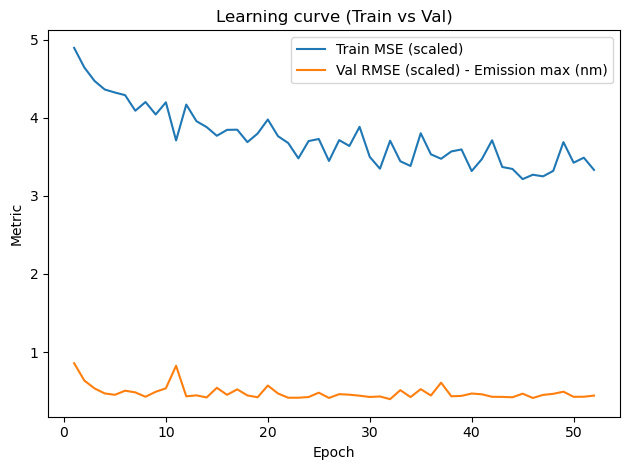

In [14]:
# 学習曲線の可視化

# history -> DataFrame
hist_df = pd.DataFrame(history)

# まず中身確認
display(hist_df.head())
print("columns:", list(hist_df.columns))

monitor_col = "Emission max (nm)"  # あなたの設定と合わせる
val_rmse_col = f"val_{monitor_col}_rmse"

plt.figure()
plt.plot(hist_df["epoch"].tolist(), hist_df["train_mse"].tolist(), label="Train MSE (scaled)")
plt.plot(hist_df["epoch"].tolist(), hist_df[val_rmse_col].tolist(), label=f"Val RMSE (scaled) - {monitor_col}")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Learning curve (Train vs Val)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# 評価・可視化用のユーティリティ関数、予測・真値・識別子をまとめて返す
@torch.no_grad()
def predict_on_loader(model, loader, device, desc=None):
    """
    Two-tower loader:
      loader yields (dye_batch, sol_batch, y)

    Returns:
      pred: [N, T]
      true: [N, T]
      dye_smiles: list[str] length N
      sol_smiles: list[str] length N
    """
    model.eval()
    all_pred, all_true = [], []
    dye_smiles_all, sol_smiles_all = [], []

    it = loader
    if desc is not None:
        it = tqdm(loader, desc=desc, leave=False)

    for dye_batch, sol_batch, y in it:
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)
        y = y.to(device).float()

        pred = model(dye_batch, sol_batch)  # [B, T]

        all_pred.append(pred.detach().cpu())
        all_true.append(y.detach().cpu())

        # PyG Batch は、各 Data の属性(smiles)を list として保持します
        if hasattr(dye_batch, "smiles"):
            dye_smiles_all.extend(list(dye_batch.smiles))
        else:
            dye_smiles_all.extend([""] * int(y.size(0)))

        if hasattr(sol_batch, "smiles"):
            sol_smiles_all.extend(list(sol_batch.smiles))
        else:
            sol_smiles_all.extend([""] * int(y.size(0)))

    pred = torch.cat(all_pred, dim=0)
    true = torch.cat(all_true, dim=0)

    n = true.shape[0]
    dye_smiles_all = dye_smiles_all[:n]
    sol_smiles_all = sol_smiles_all[:n]

    return pred, true, dye_smiles_all, sol_smiles_all

In [ ]:
# ============================================================
# 目的：回帰モデルの予測性能を「y-y（parity）プロット」で可視化するユーティリティ群
#
# 前提：
# - ここで扱う model は「色素グラフ + 溶媒グラフ」の二塔（two-tower）モデル
#   model(dye_batch, sol_batch) -> pred [B, T]
# - DataLoader は (dye_batch, sol_batch, y) を返す
# - y は robust scaling 後（*_scaled）を想定（学習と同じ空間）
#
# 出力：
# - 各ターゲットについて train と test を同一図に重ね描き（学習データの当て込み具合を確認）
# - 図の凡例に MAE / RMSE / R^2 を表示（比較しやすくする）
# ============================================================


@torch.no_grad()
def regression_metrics_torch(y_true: torch.Tensor, y_pred: torch.Tensor):
    """
    1つのターゲットに対して回帰指標（MAE / RMSE / R^2）を計算する。

    Parameters
    ----------
    y_true : torch.Tensor, shape [N]
        正解値（CPUテンソル想定。GPUでも動くが最後に .item() するためCPU推奨）
    y_pred : torch.Tensor, shape [N]
        予測値

    Returns
    -------
    mae : float
    rmse: float
    r2  : float
    """
    # 念のため float 化（学習で float を使っていても型が混ざることがあるため）
    y_true = y_true.float()
    y_pred = y_pred.float()

    resid = y_pred - y_true

    # 平均絶対誤差（MAE）
    mae = resid.abs().mean().item()

    # 二乗平均平方根誤差（RMSE）
    rmse = torch.sqrt((resid ** 2).mean()).item()

    # 決定係数（R^2）
    # R^2 = 1 - SS_res / SS_tot
    y_mean = y_true.mean()
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    ss_res = torch.sum(resid ** 2)
    r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

    return mae, rmse, r2


@torch.no_grad()
def get_pred_true_torch(model, loader, device):
    """
    DataLoader 全体を推論し、予測値と正解値を連結して返す。

    この関数のポイント：
    - 学習/評価用の DataLoader は (dye_batch, sol_batch, y) を返す（two-tower前提）
    - 推論はGPUで行うが、プロットや後処理のため CPU に戻して蓄積する

    Parameters
    ----------
    model : nn.Module
        二塔モデル。model(dye_batch, sol_batch) -> [B, T]
    loader : DataLoader
        (dye_batch, sol_batch, y) を返すローダ
    device : torch.device
        "cuda" / "cpu"

    Returns
    -------
    pred_all : torch.Tensor, shape [N, T] (CPU)
        scaled空間の予測値
    true_all : torch.Tensor, shape [N, T] (CPU)
        scaled空間の正解値
    """
    model.eval()

    preds, trues = [], []

    for dye_batch, sol_batch, y in loader:
        # GPUへ転送
        dye_batch = dye_batch.to(device)
        sol_batch = sol_batch.to(device)
        y = y.to(device).float()

        # 推論（scaled空間）
        pred = model(dye_batch, sol_batch)

        # CPUへ戻して蓄積（プロット・解析をしやすくする）
        preds.append(pred.detach().cpu())
        trues.append(y.detach().cpu())

    pred_all = torch.cat(preds, dim=0)  # [N, T]
    true_all = torch.cat(trues, dim=0)  # [N, T]

    return pred_all, true_all


def inverse_robust_torch(y_scaled: torch.Tensor, med: float, iqr: float):
    """
    robust scaling の逆変換（scaled -> raw）を行う。

    robust scaling: y_scaled = (y - med) / iqr
    inverse       : y = y_scaled * iqr + med
    """
    return y_scaled * float(iqr) + float(med)


def plot_parity_overlay_1target(
    y_true_train: torch.Tensor, y_pred_train: torch.Tensor,
    y_true_test: torch.Tensor,  y_pred_test: torch.Tensor,
    title: str, xlabel: str, ylabel: str
):
    """
    1ターゲット（例：Emission max）について、
    train（青）と test（橙）を同じ parity plot 上に重ねて描く。

    図の意図：
    - Train が極端に良いのに Test が悪い → 過学習の疑い
    - Train と Test が同程度に悪い → モデル/特徴量/データ限界の疑い
    - どのレンジで外しているか（高波長側、低波長側など）を視覚的に把握

    ここでは凡例に MAE / RMSE / R^2 を載せて比較しやすくしている。
    """
    # 指標計算（train/testを別々に）
    mae_tr, rmse_tr, r2_tr = regression_metrics_torch(y_true_train, y_pred_train)
    mae_te, rmse_te, r2_te = regression_metrics_torch(y_true_test,  y_pred_test)

    # parity line (y=x) を描くために、両データの min/max を共通軸に取る
    vmin = torch.min(torch.min(y_true_train), torch.min(y_pred_train))
    vmin = torch.min(vmin, torch.min(torch.min(y_true_test), torch.min(y_pred_test))).item()

    vmax = torch.max(torch.max(y_true_train), torch.max(y_pred_train))
    vmax = torch.max(vmax, torch.max(torch.max(y_true_test), torch.max(y_pred_test))).item()

    plt.figure()

    # Train（青：matplotlibデフォルトのC0）
    # 点が多いので alpha を下げて「密度感」を見やすくする
    plt.scatter(
        y_true_train.tolist(), y_pred_train.tolist(),
        alpha=0.35, s=12,
        label=f"Train  MAE={mae_tr:.3f} RMSE={rmse_tr:.3f} R²={r2_tr:.3f}"
    )

    # Test（橙：matplotlibデフォルトのC1）
    # train より点が少ないのでやや濃く・大きめにして視認性を確保
    plt.scatter(
        y_true_test.tolist(), y_pred_test.tolist(),
        alpha=0.65, s=16,
        label=f"Test   MAE={mae_te:.3f} RMSE={rmse_te:.3f} R²={r2_te:.3f}"
    )

    # y=x（理想線）
    plt.plot([vmin, vmax], [vmin, vmax])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_parity_overlay_all_targets(
    model, train_loader, test_loader, device, target_cols, scalers, use_raw=True
):
    """
    全ターゲット（T個）について parity overlay を順に描く。

    Parameters
    ----------
    model : nn.Module
        二塔モデル
    train_loader, test_loader : DataLoader
        (dye_batch, sol_batch, y) を返すローダ
    target_cols : list[str]
        ターゲット名のリスト（例：["Absorption max (nm)", "Emission max (nm)", "Lifetime (ns)"]）
    scalers : dict
        {col: (med, iqr)} の辞書（robust scaling の逆変換に使用）
    use_raw : bool
        True: rawスケール（nm/ns）に戻して描画（直感的）
        False: scaled空間で描画（学習空間の確認）

    Notes
    -----
    - use_raw=True の場合、各ターゲットに対して (med, iqr) が必要
    - まずは use_raw=True を推奨（物理量で誤差の大きさを解釈できるため）
    """
    # まず train/test の予測をまとめて取得（scaled空間）
    pred_tr_s, true_tr_s = get_pred_true_torch(model, train_loader, device)  # [Ntr, T]
    pred_te_s, true_te_s = get_pred_true_torch(model, test_loader,  device)  # [Nte, T]

    # 各ターゲットについて 1枚ずつ描画
    for i, col in enumerate(target_cols):

        if use_raw:
            # robust scaling の逆変換で raw（nm/ns）に戻す
            med, iqr = scalers[col]

            y_pred_tr = inverse_robust_torch(pred_tr_s[:, i], med, iqr)
            y_true_tr = inverse_robust_torch(true_tr_s[:, i], med, iqr)

            y_pred_te = inverse_robust_torch(pred_te_s[:, i], med, iqr)
            y_true_te = inverse_robust_torch(true_te_s[:, i], med, iqr)

            # 軸ラベル用の単位（列名に nm / ns が含まれている想定）
            unit = "nm" if "nm" in col else ("ns" if "ns" in col else "")
            xlabel = f"True ({unit})" if unit else "True"
            ylabel = f"Pred ({unit})" if unit else "Pred"
            title = f"Parity overlay (raw) - {col}"

        else:
            # scaled空間のまま描画（学習空間での当たり具合を見たい場合）
            y_pred_tr, y_true_tr = pred_tr_s[:, i], true_tr_s[:, i]
            y_pred_te, y_true_te = pred_te_s[:, i], true_te_s[:, i]
            xlabel = "True (scaled)"
            ylabel = "Pred (scaled)"
            title = f"Parity overlay (scaled) - {col}"

        plot_parity_overlay_1target(
            y_true_train=y_true_tr, y_pred_train=y_pred_tr,
            y_true_test=y_true_te,  y_pred_test=y_pred_te,
            title=title, xlabel=xlabel, ylabel=ylabel
        )

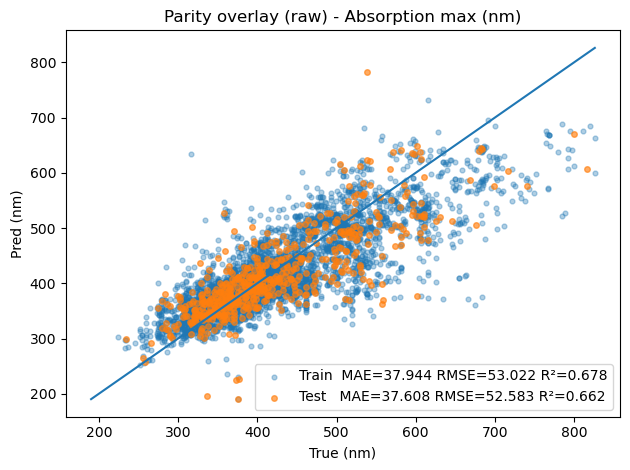

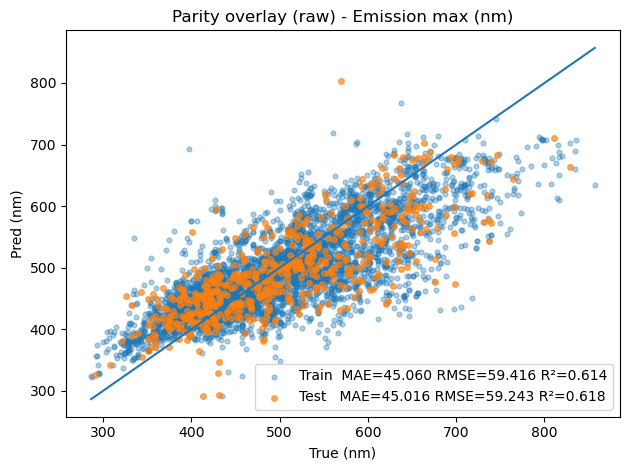

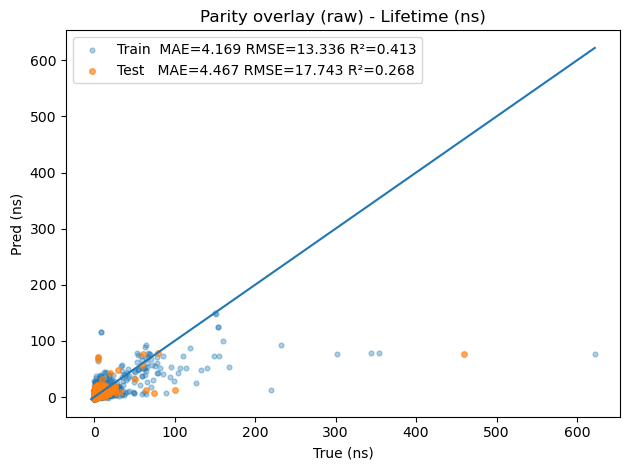

In [18]:
plot_parity_overlay_all_targets(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    target_cols=target_cols,
    scalers=scalers,
    use_raw=True,   # nm/ns
)